In [2]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits

import matplotlib
#matplotlib.use('nbagg')

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
rootdir = Path("/mnt/f/wfsdat")
# use find to make this csv list
with open(rootdir / "2020_q4_csvs.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [4]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,19261,1,binospec,19261
f5,394,1,f5,394
mmirs,6659,1,mmirs,6659
newf9,157,1,newf9,157


In [5]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
fixed = fixed[fixed['time'] > "2019-12-30"]

In [6]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,focerr,cc_x_err,cc_y_err,xcen,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms
0,2020-10-06T00:32:13.101815,f5,manual_wfs_0002.fits,30.0,1.7703,146.892986,34.394287,18.00,17.3,17.534,...,-50.56,5.853,4.425,230.994694,251.022248,0.709565,0.999586,6.264094,1300.666061,1092.979280
1,2020-10-06T00:32:13.167814,f5,manual_wfs_0003.fits,30.0,1.7542,147.682124,34.754283,18.00,17.2,17.486,...,-25.52,-0.878,-1.143,230.003448,245.015883,0.835235,1.170190,7.053696,680.259047,1224.812353
2,2020-10-06T00:32:13.229815,f5,manual_wfs_0004.fits,30.0,1.7454,148.131630,34.954193,18.00,17.2,17.477,...,-4.17,0.000,-0.000,229.015444,244.999551,1.068257,1.492151,8.514263,251.256534,1276.329554
3,2020-10-06T00:32:13.289817,f5,manual_wfs_0005.fits,30.0,1.5682,162.372508,39.619756,17.00,16.8,16.993,...,-5.82,-2.573,-3.854,239.975559,251.014650,1.112225,1.456912,8.356250,397.705872,1353.455448
4,2020-10-06T00:32:13.340815,f5,manual_wfs_0006.fits,30.0,1.5637,162.999780,39.754778,17.00,16.8,17.005,...,-13.97,-0.258,-4.247,243.997553,256.003585,0.933888,1.221201,7.287674,466.796154,1291.518667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,2020-12-28T02:09:26,mmirs,mmirs_wfs_0030.fits,30.0,1.2554,349.188640,52.801976,6.12,5.4,5.490,...,13.52,0.052,-2.255,222.008086,252.980164,1.037460,1.189161,6.241268,408.342846,1598.224181
28,2020-12-28T02:09:59,mmirs,mmirs_wfs_0031.fits,30.0,1.2558,349.106071,52.778201,6.12,5.4,5.498,...,2.92,0.000,-5.321,222.008519,252.981137,1.184076,1.357475,6.899620,509.791645,1610.491418
29,2020-12-28T02:34:53,mmirs,mmirs_wfs_0032.fits,30.0,1.2767,345.948199,51.558901,5.73,5.4,5.309,...,-22.49,2.506,-4.145,264.984598,230.005730,0.864485,1.000946,5.495958,806.629149,1426.389306
30,2020-12-28T02:35:25,mmirs,mmirs_wfs_0033.fits,30.0,1.2772,345.884191,51.532444,5.70,5.4,5.313,...,-27.34,1.258,-3.541,263.986700,230.000401,0.859235,0.995102,5.472672,837.719458,1401.052891


In [7]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<Figure size 576x360 with 0 Axes>

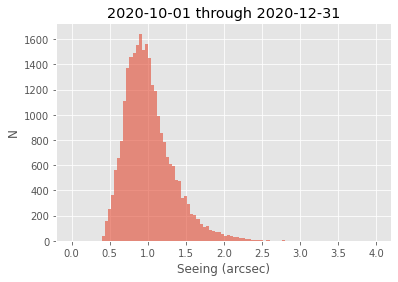

In [8]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
plt.title("2020-10-01 through 2020-12-31")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.show()

In [9]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['seeing'])
fit_median = exp_mu + loc

0.30018687877518335 0.001637749742638164 0.9717566884999169


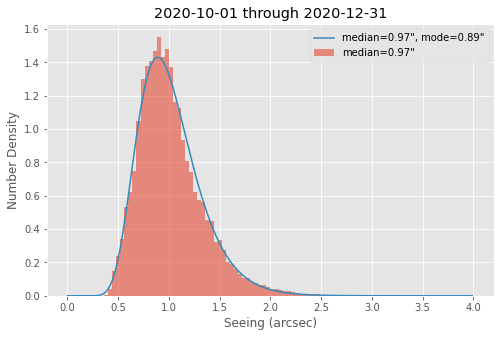

In [10]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Number Density")
plt.title("2020-10-01 through 2020-12-31")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.savefig("2020q4_hist.png")
plt.show()

In [11]:
fixed['seeing']['2020']

ut
2020-10-06 00:32:13.101815    0.709565
2020-10-06 00:32:13.167814    0.835235
2020-10-06 00:32:13.229815    1.068257
2020-10-06 00:32:13.289817    1.112225
2020-10-06 00:32:13.340815    0.933888
                                ...   
2020-12-28 02:09:26.000000    1.037460
2020-12-28 02:09:59.000000    1.184076
2020-12-28 02:34:53.000000    0.864485
2020-12-28 02:35:25.000000    0.859235
2020-12-28 02:35:57.000000    0.915528
Name: seeing, Length: 26454, dtype: float64

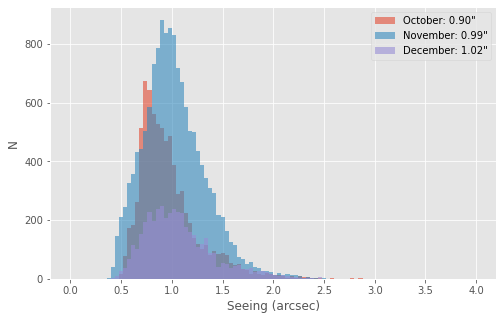

In [12]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months['October'] = fixed['seeing']['2020-10']
months['November'] = fixed['seeing']['2020-11']
months['December'] = fixed['seeing']['2020-12']
for m in months:
    plt.hist(months[m], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2020q4_monthly.png")
plt.show()

In [13]:
len(months['October']), len(months['November']), len(months['December'])

(7822, 14303, 4329)

In [14]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

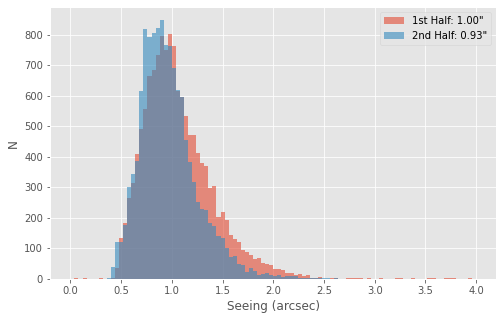

In [15]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2020q4_1st2nd.png")
plt.show()

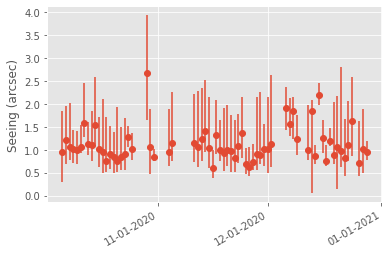

In [16]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.seeing.resample('D').median()
daily['max'] = fixed.seeing.resample('D').max()
daily['min'] = fixed.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2020q4_nightly.pdf")
plt.show()

In [17]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed['seeing'][date]) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

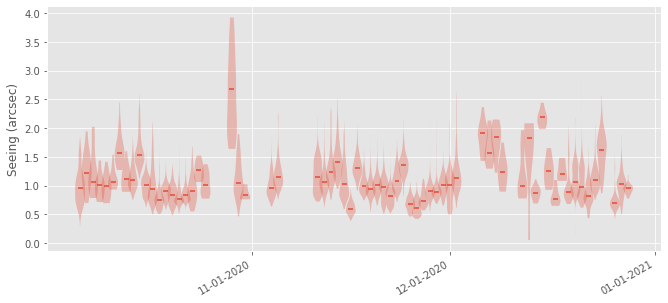

In [18]:
fig, ax = plt.subplots(figsize=(11,5))
plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
               showextrema=False, showmedians=True, bw_method='silverman')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
plt.savefig("2020q4_violin.png")
plt.show()